## 2 [indicateur](#section_2) 
## 3 [prédiction](#section_3) 
## 4 [évaluation](#section_4) 
## 5 [bot](#section_5) 

In [1]:
import pandas as pd
from binance.client import Client
import ta
import pandas_ta as pda
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

In [29]:
plus=6*60
high=0.7
low=0.5


font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

# ----- Functions Definition -------
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:
            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(14,14))
            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            else  :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            # affichage des flèches
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")         
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center',
                                 rotation=label_rotation, color="blue", alpha=0.5)           
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)     
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
def get_chop(high, low, close, window):
    tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
    tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
    tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
    atr = tr.rolling(1).mean()
    highh = high.rolling(window).max()
    lowl = low.rolling(window).min()
    ci = 100 * np.log10((atr.rolling(window).sum()) / (highh - lowl)) / np.log10(window)
    return ci


def getBalance(myclient, coin):
    jsonBalance = myclient.get_balances()
    pandaBalance = pd.DataFrame(jsonBalance)
    if pandaBalance.loc[pandaBalance['coin'] == coin].empty : return 0
    else : return float(pandaBalance.loc[pandaBalance['coin'] == coin]['free'])

def truncate(n, decimals=0):
    r = floor(float(n*0.99)*10**decimals)/10**decimals
    return str(r)


#valeur à prédire

def plus_x_fois_j(data,x=3,j=1):
    from scipy.special import cbrt #racine cubique 3
    data['plus_x']=np.nan
    for i, date in enumerate(data[:-x].index) :
        data.loc[date,'plus_x'] = cbrt((data.iloc[i+x]['close']/data.iloc[i]['close']-1)*100*j)
    return data

def plus_x_classifier_h_l(data,x=3,high=1,low=1):
    data['plus_x']=np.nan
    for i, date in enumerate(data[:-x].index) :
        v=(data.iloc[i+x]['close']/data.iloc[i]['close']-1)*100
        if   v >=  high :
            data.loc[date,'plus_x'] = 3
        elif v <= -low  :
            data.loc[date,'plus_x'] = 1
        else :
            data.loc[date,'plus_x'] = 2
    #data['plus_x_-x']=0
    #data['plus_x_-x'][x:]=data['plus_x'].values[:-x]
    data['close/close-1']=np.nan
    data['close/close-1'].iloc[60:]=data['close'].values[:-60]
    data['close/close-1']=data['close/close-1']/data['close']
    
    return data

def plus_x_ou_moins(data,x=3):
    data['plus_x']=np.nan
    for i, date in enumerate(data[:-x].index) :
        v=(data.iloc[i+x]['close']/data.iloc[i]['close']-1)*100
        if   v >=  0 :
            data.loc[date,'plus_x'] = 3
        else :
            data.loc[date,'plus_x'] = 1
    return data

#indicateur
def indicator(data, x=60):

    window_h=14*x

#    data[f'{x}_RollingMax']    = data['close']-data['close'].shift(1).rolling(window=x).max()
#    data[f'{x}_RollingMin']    = data['close'].shift(1).rolling(window=x).min()-data['close']
#    data[f'{x}_SMA']=ta.trend.sma_indicator(data['close'], window=int(x))

    #Exponential Moving Average
    data[f'{x}_SMAx*2-x*6']= ta.trend.sma_indicator(data['close'],x*2)-ta.trend.sma_indicator(data['close'], x*6)
    data[f'{x}_SMAx-x*3'] = ta.trend.sma_indicator(data['close'],window_h)-ta.trend.sma_indicator(data['close'], window_h*3)

    # #MACD
#    MACD = ta.trend.MACD(close=data['close'], window_fast=12, window_slow=26, window_sign=9)
#    data['MACD'] = MACD.macd()
#    data['MACD_SIGNAL'] = MACD.macd_signal()
#    data['MACD_DIFF'] = MACD.macd_diff() #Histogramme MACD
    
    # #Awesome Oscillator
    data[f'{x}_AWESOME_OSCILLATOR'] = ta.momentum.awesome_oscillator(high=data['high'], low=data['low'],
                                                                window1=int(window_h/7), window2=window_h)

    # # Kaufman’s Adaptive Moving Average (KAMA)
    #data['KAMA'] = ta.momentum.kama(close=data['close'], window=10, pow1=2, pow2=30)

    #Relative Strength Index (RSI)
    data[f'{x}_RSI'] =ta.momentum.rsi(close=data['close'], window=window_h)

    # #Stochastic RSI
    data[f'{x}_STOCH_RSI'] = ta.momentum.stochrsi(close=data['close'], window=window_h, smooth1=3, smooth2=3) #Non moyenné 
    #data['STOCH_RSI_D'] = ta.momentum.stochrsi_d(close=data['close'], window=window_h, smooth1=3, smooth2=3) #Orange TradingView
    #data['STOCH_RSI_K'] =ta.momentum.stochrsi_k(close=data['close'], window=window_h, smooth1=3, smooth2=3) #Bleu sur TradingView
   
    # -- Trix Indicator -- sell and buy
    trixLength = int(window_h*9/21)
    trixSignal = window_h
    data[f'{x}_TRIX_PCT'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=data['close'],
                                            window=trixLength), window=trixLength), window=trixLength).pct_change()*100
    data[f'{x}_TRIX_HISTO'] = (data[f'{x}_TRIX_PCT'] - ta.trend.sma_indicator(data[f'{x}_TRIX_PCT'],trixSignal))*100
    #data.loc[:,'buy_TRIX+0_STOCH_RSI-0.8']=0
    #data.loc[(data['TRIX_HISTO']>0) & (data['STOCH_RSI']<0.8),'buy_TRIX+0_STOCH_RSI-0.8']=1
    data.loc[:,f'{x}_buy_TRIX+0_STOCH_RSI-0.7']=data[f'{x}_TRIX_HISTO']*(data[f'{x}_STOCH_RSI']-0.7)
    data.loc[:,f'{x}_buy_TRIX+0_STOCH_RSI-0.5']=data[f'{x}_TRIX_HISTO']*(data[f'{x}_STOCH_RSI']-0.5)
    #data.loc[:,'sell_TRIX-0_STOCH_RSI+0.2_0_1']=0
    #data.loc[(data['TRIX_HISTO']<0) & (data['STOCH_RSI']>0.2),'sell_TRIX-0_STOCH_RSI+0.2_0_1']=-data.loc[:,'buy_TRIX+0_STOCH_RSI-0.8']
    data.loc[:,f'{x}_sell_TRIX-0_STOCH_RSI+0.2']=-data[f'{x}_TRIX_HISTO']*(0.2-data[f'{x}_STOCH_RSI'])
    data.loc[:,f'{x}_buy_TRIX+0_STOCH_RSI']=data[f'{x}_TRIX_HISTO']+(data[f'{x}_STOCH_RSI'])
    data=data.drop(f'{x}_STOCH_RSI',axis=1)
    
    # #Average True Range (ATR) trop de NAN
    data[f'{x}_ATR'] = ta.volatility.average_true_range(high=data['high'], low=data['low'], close=data['close'], window=window_h)

    # #Choppiness index
    data[f'{x}_CHOP'] = get_chop(high=data['high'], low=data['low'], close=data['close'], window=window_h)  
    
        # #Super Trend
    #ST_length = 10
    #ST_multiplier = 3.0
    #superTrend = pda.supertrend(high=data['high'], low=data['low'], close=data['close'], length=ST_length,
    #                            multiplier=ST_multiplier)
    #data['SUPER_TREND'] = superTrend['SUPERT_'+str(ST_length)+"_"+str(ST_multiplier)] #Valeur de la super trend   
    return data

def evaluation(data_t,best,X_test,Y_test,limit_lose=0):
    frais=0.00067
    btc=0.0
    usdt=100
    lastindex=data_t.first_valid_index()
    last_achat=0
    nbr_achat=0
    nbr_vends=0
    
    for index,row in data_t.iterrows():
        if  data_t['buy'][index] and usdt>10:
            btc =usdt/data_t['close'][index]
            btc = btc - (frais*btc)
            usdt=0
            last_achat=data_t['close'][index]
            nbr_achat+=1
            #print(f"{btc:.0f} btc                                         ",index)

        if  (data_t['sell'][index] or data_t['close'][index]<limit_lose*last_achat) and btc > 0.0001:
            usdt =btc*data_t['close'][index]
            usdt = usdt -(0.007*usdt)
            btc=0
            nbr_vends+=1
            #print(f"                      {usdt:.0f} $                     ",index)
        lastindex=index
        
    resultat=usdt +btc*data_t['close'].iloc[-1]
    #plot_confusion_matrix(best, X_test, Y_test) 
    plot_confusion_matrix(best, X_test, Y_test,normalize='true',cmap='cool')
    plt.show()
    print(f"nbr achat : {nbr_achat}     nbr vends : {nbr_vends}")
    print(f"resultat = {resultat:.0f} $    score train = {best.score(X_train, Y_train):.2f}",
          f"   score valid  : {best.score(X_valid, Y_valid):.2f}  score test  : {best.score(X_test, Y_test):.2f}")
    
    return resultat


# <a class="anchor" id="section_2"></a> indicateur

In [4]:
#gestion des dichiers
import os
from pathlib import Path
import pickle
import wget 

if not Path( r'./Data/btcusdt_train_minute.pkl').is_file() :
    print('dl le fichier dans data en cours: ')
    os.makedirs('./Data/', exist_ok=True)
    client = Client()
    klinesT = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, "01 january 2012")
    df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    df['close'] = pd.to_numeric(df['close'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['open'] = pd.to_numeric(df['open'])
    df = df.set_index(df['timestamp'])
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.drop( ['timestamp','open',
                   'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'],axis=1)
    df.to_pickle(r'./Data/btcusdt_train_minute.pkl')
else:
    df= pd.read_pickle(r'./Data/btcusdt_train_minute.pkl')
    
df=df[-int(7e4):]

df=plus_x_classifier_h_l(df,plus,high,low)
df=indicator(df,360)  
df=indicator(df,240)
df=indicator(df,480)
df=indicator(df,600)
df=indicator(df,30) 
df=indicator(df,45) 
df=indicator(df,75) 
df=indicator(df,90) 

df.describe()

C:\Users\polo1\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,high,low,close,plus_x,close/close-1,360_SMAx*2-x*6,360_SMAx-x*3,360_AWESOME_OSCILLATOR,360_RSI,360_TRIX_PCT,...,90_AWESOME_OSCILLATOR,90_RSI,90_TRIX_PCT,90_TRIX_HISTO,90_buy_TRIX+0_STOCH_RSI-0.7,90_buy_TRIX+0_STOCH_RSI-0.5,90_sell_TRIX-0_STOCH_RSI+0.2,90_buy_TRIX+0_STOCH_RSI,90_ATR,90_CHOP
count,70000.000000,70000.000000,70000.000000,69640.000000,69940.000000,67841.000000,54881.000000,64961.000000,64961.000000,63522.000000,...,68741.000000,68741.000000,68382.000000,67123.000000,67123.000000,67123.000000,67123.000000,67123.000000,70000.000000,68740.000000
mean,53184.336727,53122.885955,53153.857074,1.997028,0.999758,153.208117,1428.899981,452.626836,50.357520,0.000399,...,120.600700,50.402034,0.000410,-0.001364,0.029230,0.028957,0.028548,0.509121,60.265385,48.059426
std,7701.442559,7696.762304,7699.596665,0.785540,0.007124,804.334896,2188.380858,1608.697816,0.731245,0.001189,...,781.386765,1.324297,0.002285,0.173372,0.054101,0.043361,0.069417,0.409944,14.427008,3.878508
min,40029.890000,39600.000000,39681.000000,1.000000,0.930280,-2043.987690,-2621.333280,-3621.637157,47.604950,-0.002816,...,-2563.892409,45.071001,-0.006849,-0.584236,-0.273205,-0.195147,-0.173444,-0.448800,0.000000,36.997097
25%,46803.882500,46745.957500,46777.302500,1.000000,0.996543,-283.334023,-676.407204,-543.581050,49.811910,-0.000372,...,-319.374159,49.562233,-0.000769,-0.113759,-0.001428,0.000081,-0.009837,0.164741,53.537590,44.995926
50%,54612.870000,54548.035000,54578.660000,2.000000,0.999950,150.048028,2122.832591,566.509147,50.318233,0.000401,...,74.361548,50.458657,0.000280,-0.012981,0.014994,0.017475,0.006755,0.491377,61.194256,48.293543
75%,60989.405000,60935.282500,60964.310000,3.000000,1.003156,679.547477,3257.655624,1400.242919,50.969133,0.001110,...,586.798286,51.230709,0.001914,0.113218,0.048928,0.049900,0.054684,0.875367,68.754855,50.734032
max,67000.000000,66901.010000,66930.010000,3.000000,1.061225,2598.630889,5090.637077,4661.441929,52.504448,0.002943,...,2999.627421,55.726621,0.008302,0.513178,0.314160,0.224400,0.332960,1.415272,95.483644,58.429517


(44441, 101)


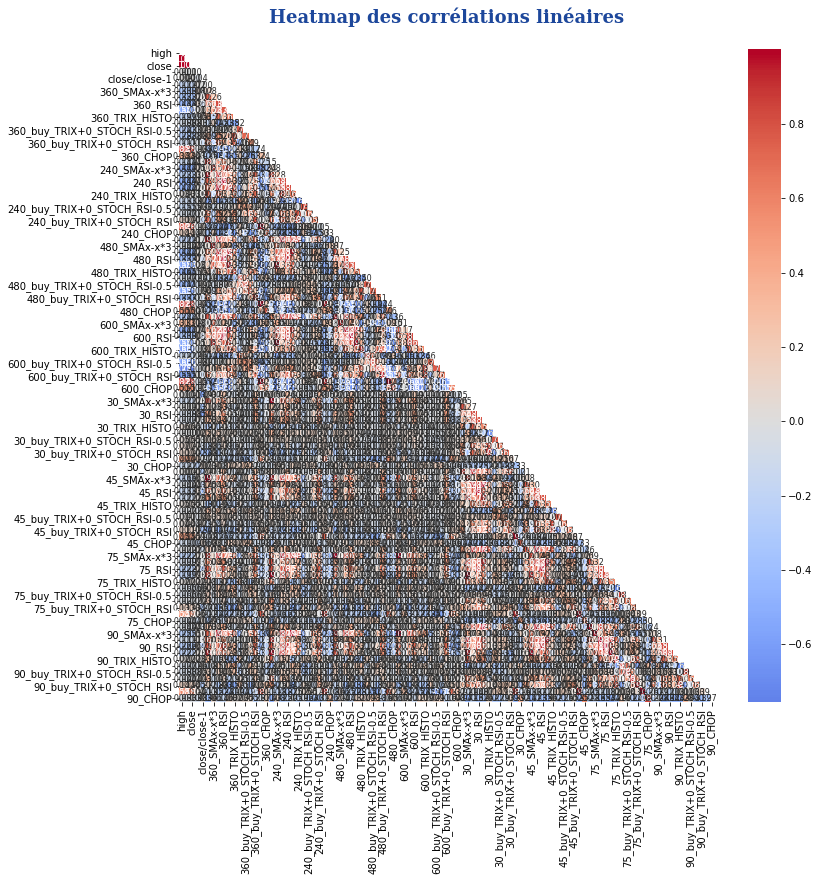

In [5]:
df=df.dropna(axis=0)
data_save=df
plus_x=df['plus_x']
data_t=df.drop('plus_x',axis=1).copy()
print(data_t.shape)
preprocessor=StandardScaler().fit(data_t)
    
data_t  = preprocessor.transform(data_t)
data_t = pd.DataFrame(index=df.dropna(axis=0).index,columns= df.drop('plus_x',axis=1).columns,data=data_t)


#data_t['sell_TRIX-0_STOCH_RSI+0.2']=data_t['sell_TRIX-0_STOCH_RSI+0.2']*2
#data_t['CHOP']=data_t['CHOP']*1

corr = data_t.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontdict=font_title);


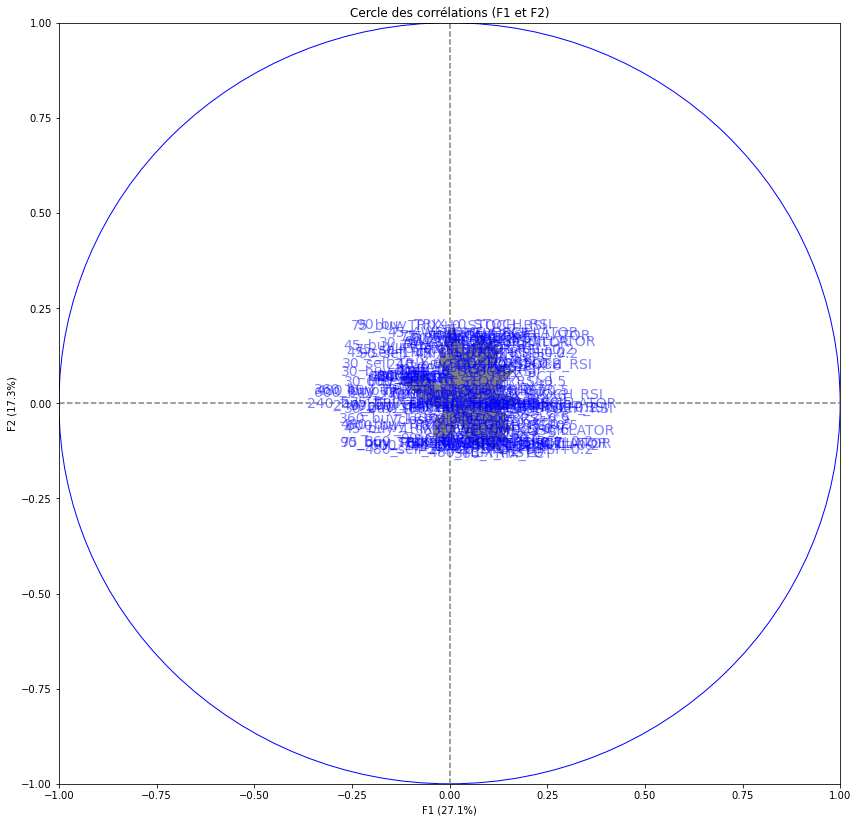

Composante ACP    1.239377e-31
Somme             1.000000e+02
Name: 97, dtype: float64

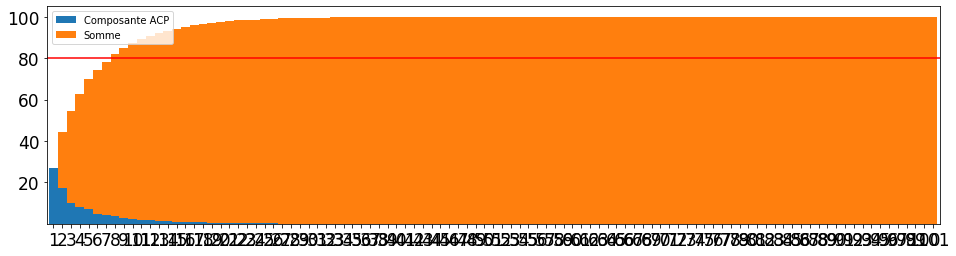

In [6]:
pca = PCA(n_components=len(data_t.columns)) #20)#  On paramètre ici pour ne garder que  composantes

# Résultats de l'ACP
data_ACP= pca.fit_transform(data_t)
data_ACP = pd.DataFrame(index=data_t.index,columns= [np.arange(1,1+len(pca.components_)).astype(str)],data=data_ACP)




Yacp = list(pca.explained_variance_ratio_*100)
Xacp = range(1,len(Yacp)+1)
ycum = np.cumsum(Yacp)

d=pd.DataFrame(index=Xacp,columns= ['Composante ACP','Somme'] )
d['Composante ACP']=Yacp
d['Somme']=ycum-Yacp


d.plot(kind='bar',stacked=True,width=1,figsize=(16,4))
plt.axhline(y=80,color="r")
#plt.xlabel("Composante de l'ACP")
#plt.ylabel('variabilité')
plt.xticks(rotation=0,size=17)
plt.yticks(size=17);
#plt.title('ACP par compossante');
d.iloc[-5,:]

preprocessor=StandardScaler().fit(data_sortie)
data_sortie=preprocessor.transform(data_sortie)
data_sortie = pd.DataFrame(index=data_t.index,columns= [np.arange(1,1+len(pca.components_)).astype(str)],data=data_sortie)

# <a class="anchor" id="section_3"></a>prédiction

In [7]:
#df=df.drop(df[:int(df.shape[0]*0.4)][df['plus_x'] ==2].index,axis=0)
#df.shape

In [10]:
X = data_t.drop(['low','high','volume','close'],axis=1).copy() # data_ACP #
Y = df['plus_x']
    
#X_train1, X_test, Y_train1, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)
multi=3
X_train1 = X[:-3600*multi]
Y_train1 = Y[:-3600*multi]
X_test   = X[-3600*multi:]
Y_test   = Y[-3600*multi:]
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1,
                                                      test_size=0.2, random_state=None,shuffle= None)#,stratify=Y_train1)



# <a class="anchor" id="section_4"></a> évaluation

In [11]:
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.linear_model import SGDClassifier
import warnings
#warnings.filterwarnings('ignore')

resultat=[]  

selector = RFECV(RandomForestClassifier(random_state=2,class_weight ='balanced'),
                 step=1,n_jobs=-2,scoring=None,
                 min_features_to_select=12,
                 cv=5).fit(X_train1,Y_train1)
print("ranking",selector.ranking_)
print("scores",selector.grid_scores_)
delete=X.columns[selector.ranking_ != 1]
print("bad features",delete)


X_train1=X_train1.drop(delete,axis=1)
X_train=X_train.drop(delete,axis=1)
X=X.drop(delete,axis=1)
X_valid=X_valid.drop(delete,axis=1)
X_test=X_test.drop(delete,axis=1)

ranking [52  1  1  4  1  1  1  1  1  1 27  1  1  5  1  1 10  1  1 37  6  1 26 18
  1 14  1  1  1  1  1  1 22  1 34  1  1  1  1  1  1  1  1  1  1  2  1  1
  1 48  1 29  1 39 33 42 49 46 41 12 44 45  9 19  1  7 11 47 51 43 32 15
 23 50  8 25 35 24  1 13 36  1 31  3  1 40  1 30 16  1  1 17 28 38 20 21
  1]
scores [0.31143215 0.31068899 0.29442858 0.31841788 0.29014796 0.29823358
 0.30756769 0.30718125 0.32118244 0.30367353 0.292318   0.32579005
 0.29704451 0.31366159 0.29992798 0.31110516 0.30964857 0.30224665
 0.30848922 0.32144999 0.31268066 0.30658671 0.32474962 0.32543333
 0.32020147 0.31678292 0.32023119 0.30361408 0.31942858 0.31969613
 0.31984478 0.32620623 0.31458316 0.31321574 0.33420266 0.31288873
 0.30254393 0.31006472 0.32932751 0.31609921 0.30563548 0.31074843
 0.31110513 0.31502899 0.31036199 0.31595058 0.32537388 0.31223477
 0.31166996 0.30819195 0.30935113 0.30245474 0.30566532 0.31844761
 0.32254987 0.31187804 0.30759742 0.31589112 0.30819195 0.30518957
 0.30890604 0.3053

delete=X.columns[selector.support_]
print("select features",delete)
len(selector.support_)-selector.support_.sum()


In [12]:
X_test

,360_SMAx*2-x*6,360_SMAx-x*3,360_RSI,360_TRIX_PCT,360_TRIX_HISTO,360_buy_TRIX+0_STOCH_RSI-0.7,360_buy_TRIX+0_STOCH_RSI-0.5,360_sell_TRIX-0_STOCH_RSI+0.2,360_ATR,360_CHOP,...,30_SMAx-x*3,30_RSI,45_RSI,75_TRIX_HISTO,75_sell_TRIX-0_STOCH_RSI+0.2,75_CHOP,90_SMAx-x*3,90_TRIX_PCT,90_TRIX_HISTO,90_CHOP
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-24 22:26:00,-0.852443,-1.122275,-1.314822,-1.769478,-0.883986,0.883066,0.359837,-0.396622,0.842635,-0.187211,...,-0.593749,0.252708,0.016435,0.092647,-0.303250,0.910816,-0.927264,-0.757988,-0.161073,1.049566
2021-10-24 22:27:00,-0.852646,-1.122933,-1.311895,-1.769331,-0.883243,0.879046,0.355724,-0.398649,0.841180,-0.172145,...,-0.589028,0.262776,0.024846,0.097269,-0.295465,0.910922,-0.926866,-0.755613,-0.157606,1.048756
2021-10-24 22:28:00,-0.852894,-1.123591,-1.311895,-1.769184,-0.882499,0.877902,0.354955,-0.398604,0.840331,-0.172312,...,-0.584388,0.262776,0.024846,0.101882,-0.288371,0.910855,-0.926486,-0.753236,-0.154140,1.049203
2021-10-24 22:29:00,-0.853202,-1.124249,-1.315922,-1.769037,-0.881755,0.880706,0.358776,-0.395716,0.839066,-0.172467,...,-0.579367,0.248156,0.012880,0.106484,-0.282408,0.911512,-0.926134,-0.750859,-0.150676,1.048344
2021-10-24 22:30:00,-0.853421,-1.124909,-1.298542,-1.768888,-0.881009,0.859515,0.334703,-0.410105,0.838236,-0.172574,...,-0.576091,0.308184,0.062954,0.111077,-0.270402,0.911772,-0.925744,-0.748479,-0.147211,1.047760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01 10:21:00,-0.236869,-1.054134,-0.679122,-0.883040,-0.259190,-0.458870,-0.728947,-0.633183,0.611517,1.572647,...,0.102785,0.802759,0.651549,0.755734,0.790062,-0.605143,-0.840755,-0.075731,0.814339,-0.212713
2021-11-01 10:22:00,-0.236367,-1.053966,-0.675590,-0.883009,-0.259324,-0.460751,-0.731234,-0.634694,0.611352,1.572084,...,0.107308,0.813486,0.660616,0.758915,0.800642,-0.604271,-0.839578,-0.072740,0.817245,-0.213716
2021-11-01 10:23:00,-0.235780,-1.053798,-0.676920,-0.882978,-0.259457,-0.460055,-0.730526,-0.634349,0.610005,1.571626,...,0.111542,0.809099,0.656989,0.762081,0.803740,-0.605126,-0.838338,-0.069751,0.820144,-0.216593


In [13]:
random_classifier = RandomForestClassifier()

parameters = { 'class_weight' :['balanced'],'min_samples_leaf': [2000,2]}

random_grid = GridSearchCV(random_classifier, parameters, cv = 5).fit(X_train1,Y_train1)
best=random_grid.best_estimator_
random_grid.best_params_

{'class_weight': 'balanced', 'min_samples_leaf': 2}

test (10800, 105)
nbr achat : 5     nbr vends : 5
resultat = 99 $    score train = 0.43    score valid  : 0.42  score test  : -1.39


99.05078851871659

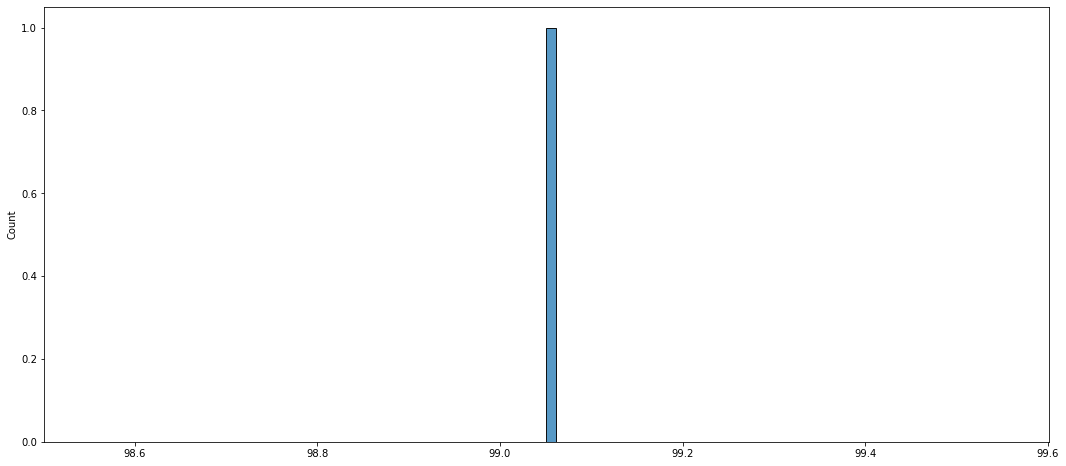

In [28]:
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.linear_model import SGDClassifier
import warnings
#warnings.filterwarnings('ignore')

resultat=[]  
  


for i in range(0,1):    


    from sklearn import linear_model

    #best =linear_model.LinearRegression().fit(X=X_train1,y= Y_train1)
    #best = RandomForestClassifier(n_jobs=-2,n_estimators=200,random_state=5).fit(X_train1, Y_train1)
    #best = SGDClassifier(random_state=0).fit(X_train, Y_train)
  
   
    df['predict']=best.predict(X)

    df.loc[:,'buy' ] = 0
    df.loc[:,'sell'] = 0
    df.loc[df['predict'] >=  2.5,'buy' ] = 1
    df.loc[df['predict'] <=  1.5,'sell'] = 1    
    data_r=df.loc[X_test.index.values,:].copy()
    print(f"test {data_r.shape}")
    resultat.append(evaluation(data_r,best,X_test,Y_test,0.4))
    
fig = plt.figure(figsize=(18, 8))
sns.histplot(resultat, bins=100)
#plt.xscale('log');
np.array(resultat).mean()

In [24]:
print(confusion_matrix( Y_test,best.predict(X_test)))
data_r['close'][-1]/data_r['close'][0]

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

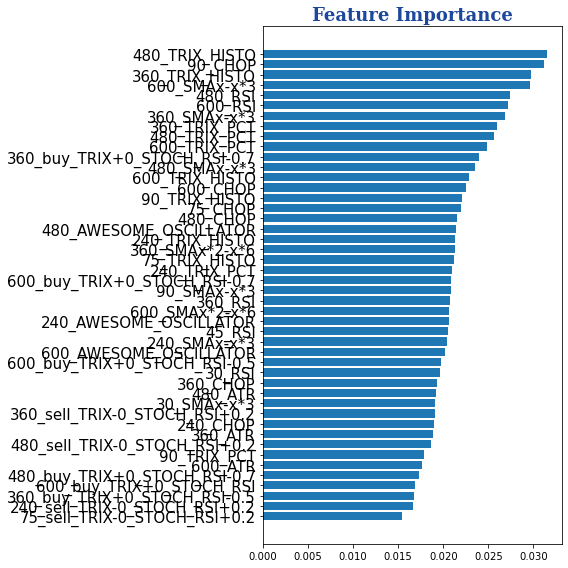

In [16]:
# Get Feature importance data using feature_importances_ attribute
feature_importance = best.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx],size=15)

plt.title('Feature Importance',fontdict=font_title)

fig.tight_layout()
plt.show()

In [17]:
from sklearn.model_selection import learning_curve

N,train_score,val_score=learning_curve(best, X_train,Y_train,train_sizes=np.linspace(0.2,1,5))


plt.plot(N,val_score.mean(axis=1),'g',label='validation')
plt.plot(N,train_score.mean(axis=1),label='train');
plt.ylabel("pourcentages d'apprentissage",fontsize=15) 
plt.xlabel("train_sizes" ,fontsize=15)  
plt.title("learning_curve", fontdict=font_title)
plt.legend();

KeyboardInterrupt: 

In [32]:
cbrt(0.1)

NameError: name 'cbrt' is not defined

In [ ]:
une couche cacher en réseau de neuronne